In [1]:
"""Manual spark configuration based on the default Spark configuration from the NXCALS bundle
and https://gitlab.cern.ch/msobiesz/spark-pipelines/-/blob/master/NXCALS-example-for-DAaaS.ipynb.
Used unless the spark context is already created. (outside of SWAN service or pyspark)
"""

if "spark" not in locals() and "spark" not in globals():
    import os
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
    import socket

    nxcals_jars = os.getenv("NXCALS_JARS")
    host_name = socket.gethostname()

    conf = SparkConf()

    conf.set("spark.master", "yarn")
    conf.set("spark.driver.host", host_name)
    conf.set("spark.driver.port", "5001")
    conf.set("spark.blockManager.port", "5101")
    conf.set("spark.ui.port", "5201")

    # adjust PYTHONPATH and LD_LIBRARY_PATH on driver
    conf.set("spark.yarn.appMasterEnv.PYTHONPATH", os.getenv("PYTHONPATH"))
    conf.set("spark.yarn.appMasterEnv.LD_LIBRARY_PATH", os.getenv("LD_LIBRARY_PATH"))

    # adjust PYTHONPATH and LD_LIBRARY_PATH on executor
    conf.set("spark.executorEnv.PYTHONPATH", os.getenv("PYTHONPATH"))
    conf.set("spark.executorEnv.LD_LIBRARY_PATH", os.getenv("LD_LIBRARY_PATH"))

    conf.set("spark.executorEnv.JAVA_HOME", os.getenv("JAVA_HOME"))
    conf.set("spark.executorEnv.SPARK_HOME", os.getenv("SPARK_HOME"))

    conf.set("spark.executorEnv.SPARK_EXTRA_CLASSPATH", os.getenv("SPARK_DIST_CLASSPATH"))

    conf.set("spark.driver.extraClassPath", nxcals_jars)
    conf.set("spark.executor.extraClassPath", nxcals_jars)
    conf.set(
        "spark.driver.extraJavaOptions",
        "-Dservice.url="
        "https://cs-ccr-nxcals5.cern.ch:19093,https://cs-ccr-nxcals5.cern.ch:19094,"
        "https://cs-ccr-nxcals6.cern.ch:19093,https://cs-ccr-nxcals6.cern.ch:19094,"
        "https://cs-ccr-nxcals7.cern.ch:19093,https://cs-ccr-nxcals7.cern.ch:19094,"
        "https://cs-ccr-nxcals8.cern.ch:19093,https://cs-ccr-nxcals8.cern.ch:19094",
    )

    sc = SparkContext(conf=conf)
    spark = SparkSession(sc)

<h1><center>Analysis of an FPA in an IT Circuit</center></h1>

The main quadrupole magnet circuits of the 8 Inner Triplet (IT) systems in the LHC are composed of four single aperture quadrupole magnets in series and have a particular powering configuration, consisting of three nested power converters (PC), see Figure below.

<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/-/raw/master/figures/it/IT.png" width=75%>
Main quadrupole magnet circuit of the Inner Triplet system for IT’s at points 1 and 5 (left) and IT’s at points 2 and 8 (right).

Note that the configuration for the IT’s in points 1 and 5 is different from the configuration in points 2 and 8. An earth detection system is present at the minus of the RTQX2 converter. Detailed information concerning the converters is given in EDMS 1054483. Note that the currents in the quadrupole magnets are given by:
\begin{equation}
I_\text{Q1} = I_\text{RQX} + I_\text{RTQX1} \\
I_\text{Q2} = I_\text{RQX} + I_\text{RTQX2} \\
I_\text{Q3} = I_\text{RQX} \\
\end{equation}

The two magnets Q1 and Q3 are type MQXA and the two combined magnets Q2a and Q2b are type MQXB. Q1 is located towards the interaction point.

Note that the IT’s at points 2 and 8 have a slightly higher nominal operating current than the IT’s at points 1 and 5, see Table 1.


|Circuit|I\_PNO RQX|I\_PNO RTQX2|I\_PNO RTQX1|
|-------|----------|------------|------------|
|RQX.L2, RQX.R2, RQX.L8, RQX.R8|7180 A| 4780 A|550 A|
|RQX.L1, RQX.R1, RQX.L5, RQX.R5|6800 A| 4600 A|550 A|


Nominal operating currents for 7 TeV of the three PC’s as given in the LHC design report volume I. For the nominal current during HWC see EDMS 1375861.


source: Test Procedure and Acceptance Criteria for the Inner Triplet Circuits in the LHC, MP3 Procedure, <a href="https://edms.cern.ch/document/874886">https://edms.cern.ch/document/874886</a>

# Analysis Assumptions
- We consider standard analysis scenarios, i.e., all signals can be queried. If a signal is missing, an analysis can raise a warning and continue or an error and abort the analysis.
- It is recommended to execute each cell one after another. However, since the signals are queried prior to analysis, any order of execution is allowed. In case an analysis cell is aborted, the following ones may not be executed (e.g. I\_MEAS not present). 

# Plot Convention
- Scales are labeled with signal name followed by a comma and a unit in square brackets, e.g., I_MEAS, [A].
- If a reference signal is present, it is represented with a dashed line.
- If the main current is present, its axis is on the left. Remaining signals are attached to the axis on the right. The legend of these signals is located on the lower left and upper right, respectively.
- The grid comes from the left axis.
- The title contains timestamp, circuit name, and signal name allowing to re-access the signal.
- The plots assigned to the left scale have colors: blue (C0) and orange (C1). Plots presented on the right have colors red (C2) and green (C3).
- Each plot has an individual time-synchronization mentioned explicitly in the description.
- If an axis has a single signal, then the color of the label matches the signal's color. Otherwise, the label color is black.

# 0. Initialise Working Environment

In [2]:
# External libraries
print("Loading (1/15)")
import pandas as pd

print("Loading (2/15)")
import numpy as np

print("Loading (3/15)")
import sys, datetime

print("Loading (4/15)")
from IPython.display import display, Javascript, clear_output, HTML

# Internal libraries
print("Loading (5/15)")
import lhcsmapi

print("Loading (6/15)")
from lhcsmapi.Time import Time

print("Loading (7/15)")
from lhcsmapi.Timer import Timer

print("Loading (8/15)")
from lhcsmapi.analysis.ItCircuitQuery import ItCircuitQuery

print("Loading (9/15)")
from lhcsmapi.analysis.ItCircuitAnalysis import ItCircuitAnalysis

print("Loading (10/15)")
from lhcsmapi.analysis.expert_input import get_expert_decision

print("Loading (11/15)")
from lhcsmapi.analysis.report_template import apply_report_template

print("Loading (12/15)")
from lhcsmapi.gui.DateTimeBaseModule import DateTimeBaseModule

print("Loading (13/15)")
from lhcsmapi.gui.pc.FgcPmSearchModuleMediator import FgcPmSearchModuleMediator

print("Loading (14/15)")
from lhcsmnb.parameters import are_all_parameters_injected, NbType

print("Loading (15/15)")
import lhcsmnb.utils

clear_output()
lhcsmapi.get_lhcsmapi_version()
lhcsmapi.get_lhcsmhwc_version("../__init__.py")

Analysis executed with lhc-sm-api version: 1.5.18
Analysis executed with lhc-sm-hwc notebooks version: 1.5.66


In [3]:
path_to_notebook = "./AN_IT_FPA_SNAP.ipynb"
report_destination_path_template = "/eos/project/m/mp3/IT/{}/FPA"  # circuit_name
report_filename_template = "{}_FPA-{}-{}"  # circuit_name, date_time_fgc, analysis_time, board_number

# 1. Select FGC Post Mortem Entry

In order to perform the analysis of a FPA in an IT circuit please:
1. Select circuit name (e.g., RQX.R1)
2. Choose start and end time
3. Choose analysis mode (Automatic by default)

Once these inputs are provided, click 'Find FGC PM entries' button. This will trigger a search of the PM database in order to provide a list of timestamps of FGC events associated with the selected circuit name for the provided period of time. Select one timestamp from the 'FGC PM Entries' list to be processed by the following cells.

**Note that 24 hours is the maximum duration of a single PM query for an event. To avoid delays in querying events, please restrict your query duration as much as possible.**

In [4]:
# Pre-define a time window for searching the FPA-events, by default 48 hours from now
search_end = datetime.datetime.now().astimezone()
search_start = search_end - datetime.timedelta(days=2)

In [5]:
circuit_type = "IT"
fgc_pm_search = FgcPmSearchModuleMediator(
    DateTimeBaseModule(start_date_time=search_start.isoformat(sep=" "), end_date_time=search_end.isoformat(sep=" ")),
    circuit_type=circuit_type,
)

In [6]:
# Parameters
circuit_name = "RQX.L5"
timestamp_fgc = 1611929411340000000
author = "test"
is_automatic = True
path_to_notebook = "./results/notebooks/result_AN_IT_FPA.ipynb"
report_destination_path_template = "./results/reports"
report_filename_template = "AN_IT_FPA"
parametrized_marker = None

# 2. Query All Signals Prior to Analysis

In [7]:
with Timer():
    if not are_all_parameters_injected(NbType.FGC, locals()):
        circuit_name = fgc_pm_search.get_fgc_circuit()
        timestamp_fgc = fgc_pm_search.get_fgc_timestamp()
        author = fgc_pm_search.get_author()
        is_automatic = fgc_pm_search.is_automatic_mode()

    it_query = ItCircuitQuery(circuit_type, circuit_name, max_executions=13)

    # PIC
    timestamp_pic = it_query.find_timestamp_pic(timestamp_fgc, spark=spark)

    # PC
    source_timestamp_fgc_df = it_query.find_source_timestamp_pc(
        t_start=timestamp_fgc - int(1e9), t_end=timestamp_fgc + int(1e9)
    )

    source_fgc_rqx, timestamp_fgc_rqx = it_query.split_source_timestamp_fgc(source_timestamp_fgc_df, "RQX")
    source_fgc_rtqx1, timestamp_fgc_rtqx1 = it_query.split_source_timestamp_fgc(source_timestamp_fgc_df, "RTQX1")
    source_fgc_rtqx2, timestamp_fgc_rtqx2 = it_query.split_source_timestamp_fgc(source_timestamp_fgc_df, "RTQX2")

    i_meas_rqx_df, i_ref_rqx_df, i_a_rqx_df, i_earth_rqx_df = it_query.query_pc_pm_with_source(
        timestamp_fgc_rqx, timestamp_fgc_rqx, source_fgc_rqx, signal_names=["I_MEAS", "I_REF", "I_A", "I_EARTH"]
    )
    i_meas_rtqx1_df, i_ref_rtqx1_df, i_a_rtqx1_df, i_earth_rtqx1_df = it_query.query_pc_pm_with_source(
        timestamp_fgc_rtqx1, timestamp_fgc_rtqx1, source_fgc_rtqx1, signal_names=["I_MEAS", "I_REF", "I_A", "I_EARTH"]
    )
    i_meas_rtqx2_df, i_ref_rtqx2_df, i_a_rtqx2_df, i_earth_rtqx2_df = it_query.query_pc_pm_with_source(
        timestamp_fgc_rtqx2, timestamp_fgc_rtqx2, source_fgc_rtqx2, signal_names=["I_MEAS", "I_REF", "I_A", "I_EARTH"]
    )

    i_meas_q1_df = pd.DataFrame(
        index=i_meas_rqx_df.index, data=i_meas_rqx_df.values + i_meas_rtqx1_df.values, columns=["I_MEAS_Q1"]
    )
    i_meas_q2_df = pd.DataFrame(
        index=i_meas_rqx_df.index, data=i_meas_rqx_df.values + i_meas_rtqx2_df.values, columns=["I_MEAS_Q2"]
    )
    i_meas_q3_df = pd.DataFrame(index=i_meas_rqx_df.index, data=i_meas_rqx_df.values, columns=["I_MEAS_Q3"])

    # QDS
    source_timestamp_qds_df = it_query.find_source_timestamp_qds_board_ab(
        timestamp_fgc_rqx, duration=[(2, "s"), (2, "s")]
    )
    timestamp_qds = lhcsmnb.utils.get_at(source_timestamp_qds_df, 0, "timestamp", default=np.nan)

    u_res_q1_df, u_res_q2_df, u_res_q3_df = it_query.query_qds_pm(
        timestamp_qds, timestamp_qds, signal_names=["U_RES_Q1", "U_RES_Q2", "U_RES_Q3"]
    )
    u_1_q1_df, u_1_q2_df, u_1_q3_df = it_query.query_qds_pm(
        timestamp_qds, timestamp_qds, signal_names=["U_1_Q1", "U_1_Q2", "U_1_Q3"]
    )
    u_2_q1_df, u_2_q2_df, u_2_q3_df = it_query.query_qds_pm(
        timestamp_qds, timestamp_qds, signal_names=["U_2_Q1", "U_2_Q2", "U_2_Q3"]
    )

    # QH
    u_hds_dfss = it_query.query_qh_pm(source_timestamp_qds_df, signal_names=["U_HDS"])
    u_hds_dfs = u_hds_dfss[0] if u_hds_dfss else []

    # # Reference
    u_hds_ref_dfss = it_query.query_qh_pm(source_timestamp_qds_df, signal_names=["U_HDS"], is_ref=True)
    u_hds_ref_dfs = u_hds_ref_dfss[0] if u_hds_ref_dfss else []

    # LEADS
    u_hts_dfs = it_query.query_leads(
        timestamp_fgc,
        source_timestamp_qds_df,
        system="LEADS",
        signal_names=["U_HTS"],
        spark=spark,
        duration=[(300, "s"), (900, "s")],
    )
    u_res_dfs = it_query.query_leads(
        timestamp_fgc,
        source_timestamp_qds_df,
        system="LEADS",
        signal_names=["U_RES"],
        spark=spark,
        duration=[(300, "s"), (900, "s")],
    )

    # Results Table
    results_table = it_query.create_report_analysis_template(
        timestamp_fgc=timestamp_fgc_rqx, init_file_path="../__init__.py", author=author
    )
    it_analysis = ItCircuitAnalysis(circuit_type, results_table, is_automatic=is_automatic)

    timestamp_dct = {
        "FGC_RQX": timestamp_fgc_rqx,
        "FGC_RTQX1": timestamp_fgc_rtqx1,
        "FGC_RTQX2": timestamp_fgc_rtqx2,
        "PIC": timestamp_pic,
        "QDS_A": lhcsmnb.utils.get_at(source_timestamp_qds_df, 0, "timestamp", default=float("nan")),
        "QDS_B": lhcsmnb.utils.get_at(source_timestamp_qds_df, 1, "timestamp", default=float("nan")),
    }

	Querying NXCALS signal(s) RQX.L5:ST_ABORT_PIC from 2021-01-29 15:10:10.340 to 2021-01-29 15:11:11.340


	Querying PM event timestamps for system: FGC, className: lhc_self_pmd, source: RPHFC.USC55.RQX.L5, RPMBC.USC55.RTQX1.L5, RPHGC.USC55.RTQX2.L5 from 2021-01-29 15:10:10.340 to 2021-01-29 15:10:12.340


	Querying PM event signal(s) IAB.I_A, STATUS.I_MEAS, IEARTH.I_EARTH, STATUS.I_REF for system: RPHFC.USC55.RQX.L5, className: lhc_self_pmd, source: FGC at 2021-01-29 15:10:11.340


	Querying PM event signal(s) IAB.I_A, STATUS.I_MEAS, IEARTH.I_EARTH, STATUS.I_REF for system: RPMBC.USC55.RTQX1.L5, className: lhc_self_pmd, source: FGC at 2021-01-29 15:10:11.340


	Querying PM event signal(s) IAB.I_A, STATUS.I_MEAS, IEARTH.I_EARTH, STATUS.I_REF for system: RPHGC.USC55.RTQX2.L5, className: lhc_self_pmd, source: FGC at 2021-01-29 15:10:11.340


	Querying PM event timestamps for system: QPS, className: DQAMGNC, source: RQX.L5 from 2021-01-29 15:10:09.340 to 2021-01-29 15:10:13.340


	Querying PM event signal(s) circ.RQX.L5:U_RES_Q2, circ.RQX.L5:U_RES_Q1, circ.RQX.L5:U_RES_Q3 for system: RQX.L5, className: DQAMGNC, source: QPS at 2021-01-29 15:10:11.324


	Querying PM event signal(s) circ.RQX.L5:U_1_Q3, circ.RQX.L5:U_1_Q1, circ.RQX.L5:U_1_Q2 for system: RQX.L5, className: DQAMGNC, source: QPS at 2021-01-29 15:10:11.324


	Querying PM event signal(s) circ.RQX.L5:U_2_Q3, circ.RQX.L5:U_2_Q1, circ.RQX.L5:U_2_Q2 for system: RQX.L5, className: DQAMGNC, source: QPS at 2021-01-29 15:10:11.324


Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

Querying PM:   0%|          | 0/1 [00:00<?, ?it/s]

	Querying PM event signal(s) stat.DFLX.3L5.RQX.L5.LD1:U_HTS, stat.DFLX.3L5.RQX.L5.LD2:U_HTS, stat.DFLX.3L5.RQX.L5.LD3:U_HTS, stat.DFLX.3L5.RQX.L5.LD4:U_HTS for system: RQX.L5, className: DQAMGNC, source: QPS at 2021-01-29 15:10:11.324


	Querying PM event signal(s) stat.DFLX.3L5.RQX.L5.LD2:U_RES, stat.DFLX.3L5.RQX.L5.LD1:U_RES, stat.DFLX.3L5.RQX.L5.LD3:U_RES, stat.DFLX.3L5.RQX.L5.LD4:U_RES for system: RQX.L5, className: DQAMGNC, source: QPS at 2021-01-29 15:10:11.324


Elapsed: 26.650 s.


# 3. Timestamps
The analysis for MP3 consists of checking the existence of PM file and of consistency of the PM timestamps (PC, QPS). 
In short the following criteria should be checked:
- The PC timestamp (51_self) is QPS timestamp +-20 ms. 
- The difference between QPS board A and B timestamp = 1ms.

If one or more of these conditions are not fulfilled, then an in-depth analysis has to be performed by the QPS team.

In [8]:
it_analysis.create_timestamp_table(timestamp_dct)
t_quench = (timestamp_dct["FGC_RQX"] - timestamp_dct["QDS_A"]) * int(1e-9)
print(t_quench)

0


QDS Board B not present in PM buffer!


# 4. PC
## 4.1. Main Current

*ANALYSIS*:  
- calculation of the ramp rate
- calculation of the duration of a plateau prior to a quench
- calculation of DCCT MIIts

*GRAPHS*:  
- t = 0 s corresponds to the FGC timestamp
- one plot for each power converter


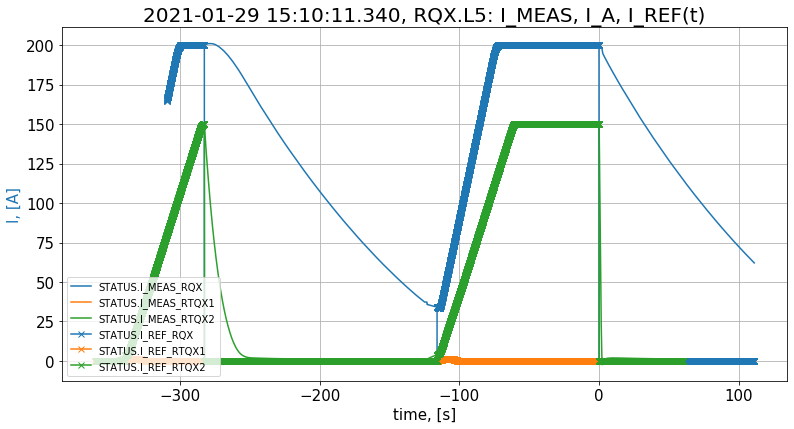

In [9]:
import matplotlib as mpl

mpl.rcParams["savefig.dpi"] = 80
mpl.rcParams["figure.dpi"] = 80
%matplotlib inline
it_analysis.plot_i_meas_pc(
    circuit_name,
    timestamp_fgc_rqx,
    [i_meas_rqx_df, i_meas_rtqx1_df, i_meas_rtqx2_df, i_ref_rqx_df, i_ref_rtqx1_df, i_ref_rtqx2_df],
)

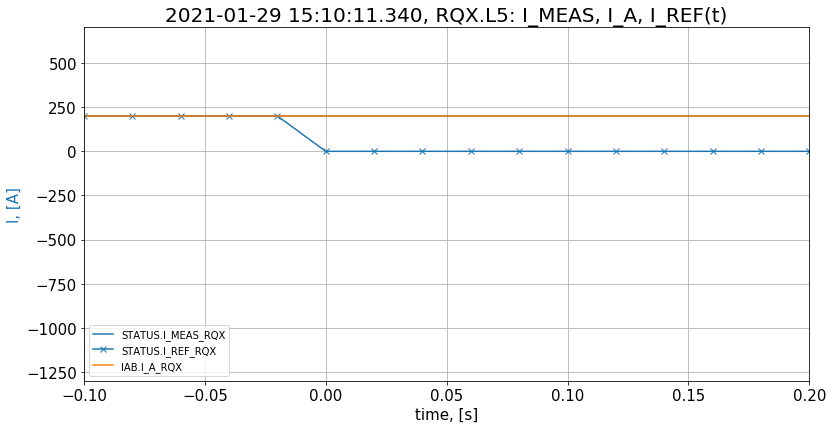

Last di/dt prior to an FPA is 0.000000 A/s.
Duration of the last di/dt prior to an FPA is 71.760000 s (as seen in the PM buffer).
I_Q_RQX is 200.0 A.
MIITS_RQX is 1.871 MA^2s from t_1 = 0.000000 s (quench detection) to t_2 = 111.160000 s (end of PM buffer).


In [10]:
if not i_meas_rqx_df.empty:
    it_analysis.plot_i_meas_pc(
        circuit_name,
        timestamp_fgc_rqx,
        [i_meas_rqx_df, i_a_rqx_df, i_ref_rqx_df],
        xlim=(-0.1, 0.2),
        ylim=(i_meas_rqx_df.max().values[0] - 1500, i_meas_rqx_df.max().values[0] + 500),
    )

    it_analysis.calculate_current_slope(
        i_meas_rqx_df.rename(columns={"STATUS.I_MEAS_RQX": "STATUS.I_MEAS"}),
        col_name=["Ramp rate RQX", "Plateau duration RQX"],
    )
else:
    print("I_MEAS_RQX_DF empty. Skipping calculate_current_slope analysis")

it_analysis.calculate_quench_current(i_meas_rqx_df, t_quench, col_name="I_Q_RQX")
if np.isnan(timestamp_dct.get("QDS_A", np.nan)) and np.isnan(timestamp_dct.get("QDS_B", np.nan)):
    print("There is no QH discharge. MIITS calculation is skipped")
else:
    it_analysis.calculate_current_miits_i_meas_i_a(i_meas_rqx_df, i_a_rqx_df, t_quench, col_name="MIITS_RQX")

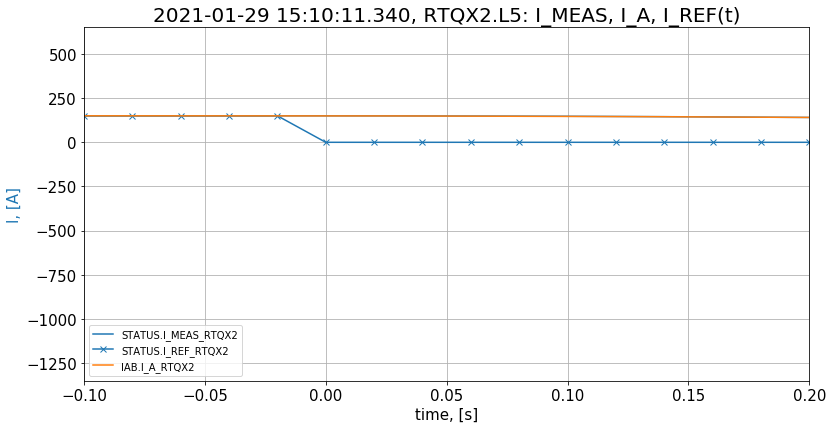

Last di/dt prior to an FPA is 0.000000 A/s.
Duration of the last di/dt prior to an FPA is 59.920000 s (as seen in the PM buffer).
I_Q_RTQX2 is 150.0 A.
MIITS_RTQX2 is 0.01409 MA^2s from t_1 = 0.000000 s (quench detection) to t_2 = 4.087000 s (end of PM buffer).


In [11]:
if not i_meas_rtqx2_df.empty:
    it_analysis.plot_i_meas_pc(
        circuit_name.replace("RQX", "RTQX2"),
        timestamp_fgc_rqx,
        [i_meas_rtqx2_df, i_a_rtqx2_df, i_ref_rtqx2_df],
        xlim=(-0.1, 0.2),
        ylim=(i_meas_rtqx2_df.max().values[0] - 1500, i_meas_rtqx2_df.max().values[0] + 500),
    )

    it_analysis.calculate_current_slope(
        i_meas_rtqx2_df.rename(columns={"STATUS.I_MEAS_RTQX2": "STATUS.I_MEAS"}),
        col_name=["Ramp rate RTQX2", "Plateau duration RTQX2"],
    )
else:
    print("I_MEAS_RTQX2_DF empty. Skipping calculate_current_slope analysis")

it_analysis.calculate_quench_current(i_meas_rtqx2_df, t_quench, col_name="I_Q_RTQX2")
if np.isnan(timestamp_dct.get("QDS_A", np.nan)) and np.isnan(timestamp_dct.get("QDS_B", np.nan)):
    print("There is no QH discharge. MIITS calculation is skipped")
else:
    it_analysis.calculate_current_miits_i_meas_i_a(i_meas_rtqx2_df, i_a_rtqx2_df, t_quench, col_name="MIITS_RTQX2")

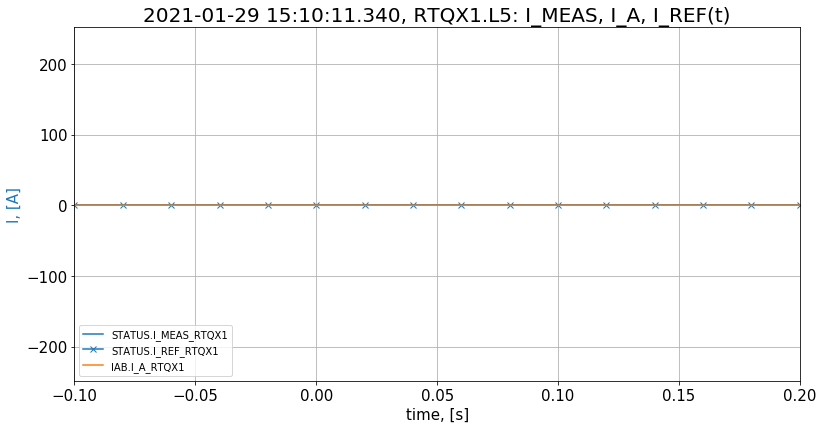

Last di/dt prior to an FPA is -0.000000 A/s.
Duration of the last di/dt prior to an FPA is 99.900000 s (as seen in the PM buffer).
I_Q_RTQX1 is 0.0 A.
MIITS_RTQX1 is 0.0 MA^2s from t_1 = 0.000000 s (quench detection) to t_2 = 60.000000 s (end of PM buffer).


In [12]:
if not i_meas_rtqx1_df.empty:
    it_analysis.plot_i_meas_pc(
        circuit_name.replace("RQX", "RTQX1"),
        timestamp_fgc_rqx,
        [i_meas_rtqx1_df, i_a_rtqx1_df, i_ref_rtqx1_df],
        xlim=(-0.1, 0.2),
        ylim=(i_meas_rtqx1_df.max().values[0] - 250, i_meas_rtqx1_df.max().values[0] + 250),
    )

    it_analysis.calculate_current_slope(
        i_meas_rtqx1_df.rename(columns={"STATUS.I_MEAS_RTQX1": "STATUS.I_MEAS"}),
        col_name=["Ramp rate RTQX1", "Plateau duration RTQX1"],
    )
else:
    print("I_MEAS_RTQX1_DF empty. Skipping calculate_current_slope analysis")
it_analysis.calculate_quench_current(i_meas_rtqx1_df, t_quench, col_name="I_Q_RTQX1")
if np.isnan(timestamp_dct.get("QDS_A", np.nan)) and np.isnan(timestamp_dct.get("QDS_B", np.nan)):
    print("There is no QH discharge. MIITS calculation is skipped")
else:
    it_analysis.calculate_current_miits_i_meas_i_a(i_meas_rtqx1_df, i_a_rtqx1_df, t_quench, col_name="MIITS_RTQX1")

## 4.2. Magnet Current

*ANALYSIS*:  
- calculation of the quench current

*GRAPHS*:  
- t = 0 s corresponds to the FGC timestamp
- one plot for each magnet

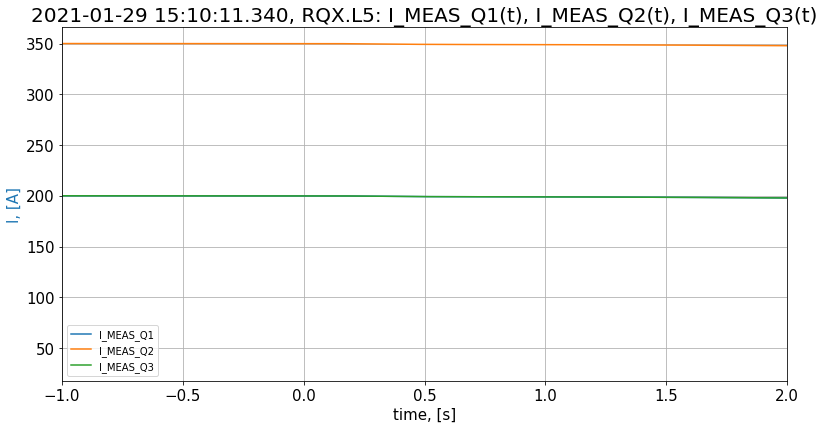

I_Q_Q1 is 200.0 A.
I_Q_Q2 is 349.3 A.
I_Q_Q3 is 200.0 A.


In [13]:
it_analysis.plot_magnet_current(circuit_name, timestamp_fgc, i_meas_q1_df, i_meas_q2_df, i_meas_q3_df)

t_quench_q1 = 0 if u_res_q1_df.empty else it_analysis.find_start_end_quench_detection(u_res_q1_df)[0]
t_quench_q2 = 0 if u_res_q2_df.empty else it_analysis.find_start_end_quench_detection(u_res_q2_df)[0]
t_quench_q3 = 0 if u_res_q3_df.empty else it_analysis.find_start_end_quench_detection(u_res_q3_df)[0]

it_analysis.calculate_quench_current(i_meas_q1_df, t_quench_q1, col_name="I_Q_Q1")
it_analysis.calculate_quench_current(i_meas_q2_df, t_quench_q2, col_name="I_Q_Q2")
it_analysis.calculate_quench_current(i_meas_q3_df, t_quench_q3, col_name="I_Q_Q3")

## 4.3. Earth Current

*ANALYSIS*:  
- calculation of the maximum earth current

*GRAPHS*:  
- t = 0 s corresponds to the FGC timestamp
- one plot for RTQX2 power converter

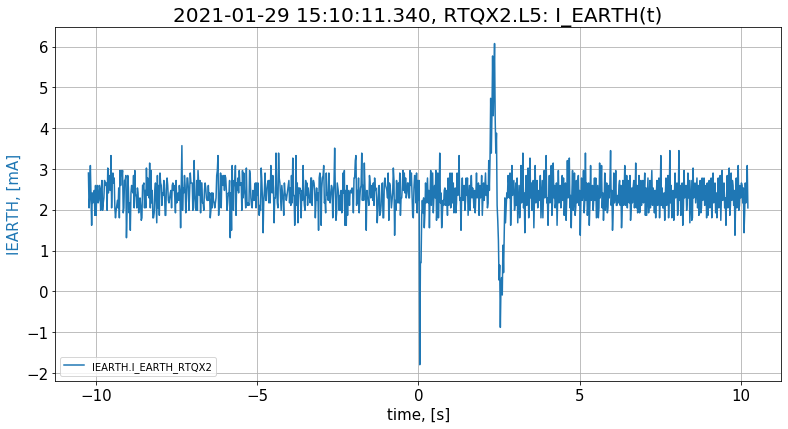

The maximum unbiased abs(I_EARTH) is -4.15 mA.


In [14]:
it_analysis.plot_i_earth_pc(circuit_name.replace("RQX", "RTQX2"), timestamp_fgc_rtqx2, i_earth_rtqx2_df)
it_analysis.calculate_max_i_earth_pc(i_earth_rtqx2_df, col_name="I_Earth_max")

# 5. Quench Protection System

The signal names used for quench detection are shown in Figure below (picture from A. Erokhin). 

<img src="https://gitlab.cern.ch/LHCData/lhc-sm-hwc/-/raw/master/figures/it/IT_QPS_Signals.png" width=50%>

A quench in the superconducting circuits is detected and all the quench heaters are fired as soon as one of the following signals exceeds the threshold.

\begin{equation}
U_\text{RES,Q1} = U_\text{1,Q1} + U_\text{2,Q1} \\
U_\text{RES,Q2} = U_\text{1,Q2} + U_\text{2,Q2} \\
U_\text{RES,Q3} = U_\text{1,Q3} + U_\text{2,Q3} \\
\end{equation}

More details on the QPS system and the quench heaters can be found on the MP3 web site (https://cern.ch/MP3).

## 5.1. Resistive Voltage

*ANALYSIS*: 
- Initial voltage slope of U_RES signal. The slope is calculated as a ratio of the voltage change from 50 to 200 mV and the corresponding time change.
- Origin of a quench, i.e., name of the first magnet for which the U_RES voltage exceeded the 100 mV threshold.

*GRAPHS*:  

t = 0 s corresponds to the QPS timestamp

In [15]:
it_analysis.plot_u_res_q1_q2_q3(circuit_name, timestamp_qds, u_res_q1_df, u_res_q2_df, u_res_q3_df)
it_analysis.find_quench_origin([u_res_q1_df, u_res_q2_df, u_res_q3_df])

Quench origin is Q2.


dU_RES_dt_Q1 =  nan V/s.


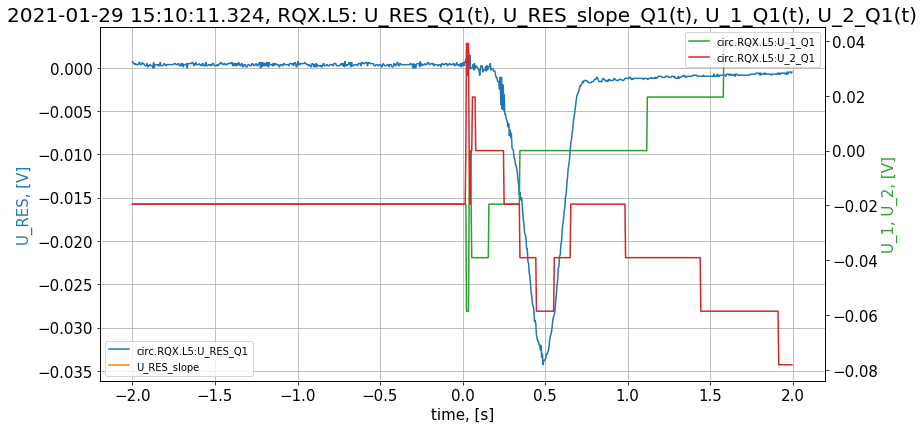

In [16]:
u_res_q1_slope_df = it_analysis.calculate_u_res_slope(u_res_q1_df, col_name="dU_RES_dt_Q1")
it_analysis.plot_u_res_u_res_slope_u_1_u_2(
    circuit_name, timestamp_qds, u_res_q1_df, u_res_q1_slope_df, u_1_q1_df, u_2_q1_df, suffix="_Q1"
)

dU_RES_dt_Q2 = 2.083 V/s.


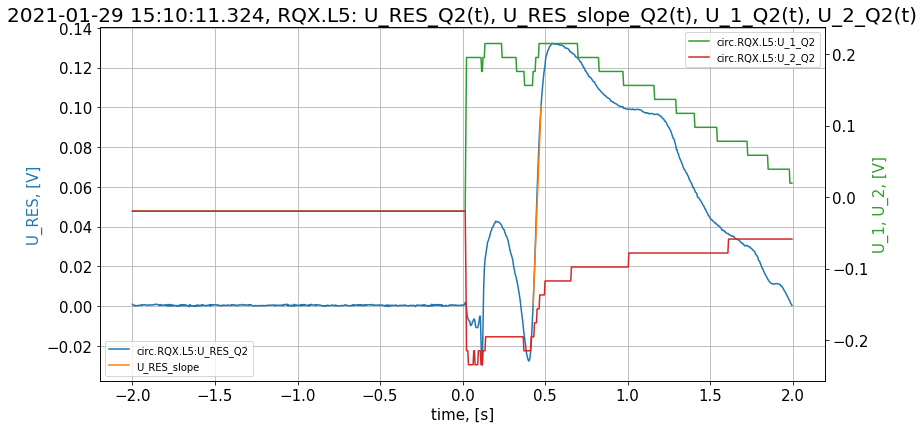

In [17]:
u_res_q2_slope_df = it_analysis.calculate_u_res_slope(u_res_q2_df, col_name="dU_RES_dt_Q2")
it_analysis.plot_u_res_u_res_slope_u_1_u_2(
    circuit_name, timestamp_qds, u_res_q2_df, u_res_q2_slope_df, u_1_q2_df, u_2_q2_df, suffix="_Q2"
)

dU_RES_dt_Q3 =  nan V/s.


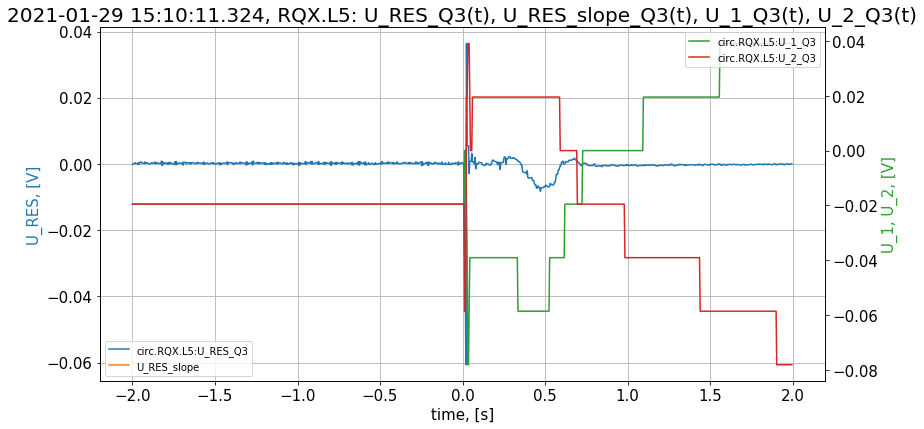

In [18]:
u_res_q3_slope_df = it_analysis.calculate_u_res_slope(u_res_q3_df, col_name="dU_RES_dt_Q3")
it_analysis.plot_u_res_u_res_slope_u_1_u_2(
    circuit_name, timestamp_qds, u_res_q3_df, u_res_q3_slope_df, u_1_q3_df, u_2_q3_df, suffix="_Q3"
)

## 5.2. Current Leads

*CRITERIA*:  
- quench detection for U_HTS for 2 consecutive datapoints above the threshold of 3 mV
- detection for U_RES for 2 consecutive datapoints above the threshold of 100 mV

*GRAPHS*:  
- t = 0 s corresponds to the LEADS timestamp.

In [19]:
it_analysis.analyze_leads_voltage(
    u_hts_dfs,
    circuit_name,
    timestamp_fgc,
    timestamp_qps=timestamp_qds,
    signal="U_HTS",
    value_min=-0.003,
    value_max=0.003,
)

stat.DFLX.3L5.RQX.L5.LD1:U_HTS outside of the [-0.003, 0.003] threshold


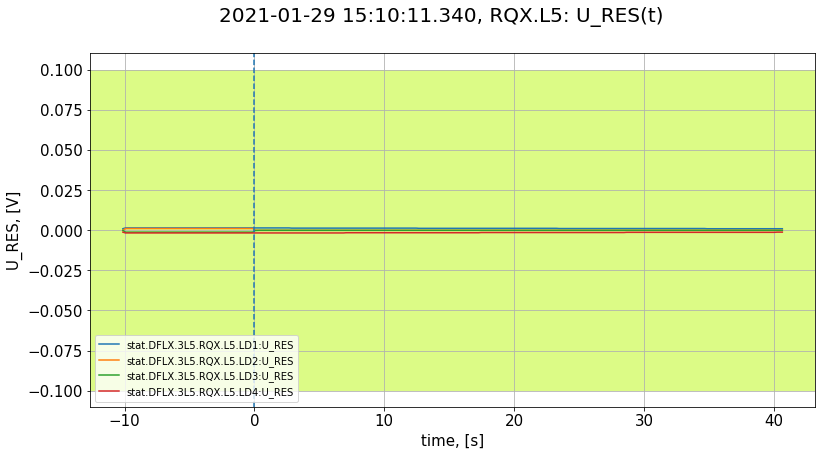

In [20]:
it_analysis.analyze_leads_voltage(
    u_res_dfs, circuit_name, timestamp_fgc, timestamp_qps=timestamp_qds, signal="U_RES", value_min=-0.1, value_max=0.1
)

In [21]:
if not is_automatic:
    it_analysis.results_table["FPA Reason"] = get_expert_decision(
        "Reason for FPA: ",
        [
            "QPS trip",
            "Converter trip",
            "EE spurious opening",
            "Spurious heater firing",
            "Busbar quench",
            "Magnet quench",
            "HTS current lead quench",
            "RES current lead overvoltage",
            "No quench",
            "Unknown",
        ],
    )
    it_analysis.results_table["Type of Quench"] = get_expert_decision(
        "Type of Quench: ",
        [
            "Training",
            "Heater-provoked",
            "Beam-induced",
            "GHe propagation",
            "QPS crate reset",
            "Single Event Upset",
            "Short-to-ground",
            "EM disturbance",
            "No quench",
            "Unknown",
        ],
    )
    it_analysis.results_table["QDS trigger origin"] = get_expert_decision(
        "QDS trigger origin: ", ["QPS", "HTS current lead", "RES current lead", "Busbar", "No quench"]
    )

## 5.3. Quench Heaters

*CRITERIA*:
- all characteristic times of an exponential decay calculated with the 'charge' approach for voltage is +/- 5 ms from the reference ones
- the initial voltage should be between 810 V and 1000 V
- the final voltage should be between 0 V and 10 V

*GRAPHS*:

t = 0 s corresponds to the start of the pseudo-exponential decay

Voltage view (linear and log)
- the queried and filtered quench heater voltage on the left axis (actual signal continuous, reference dashed), U_HDS

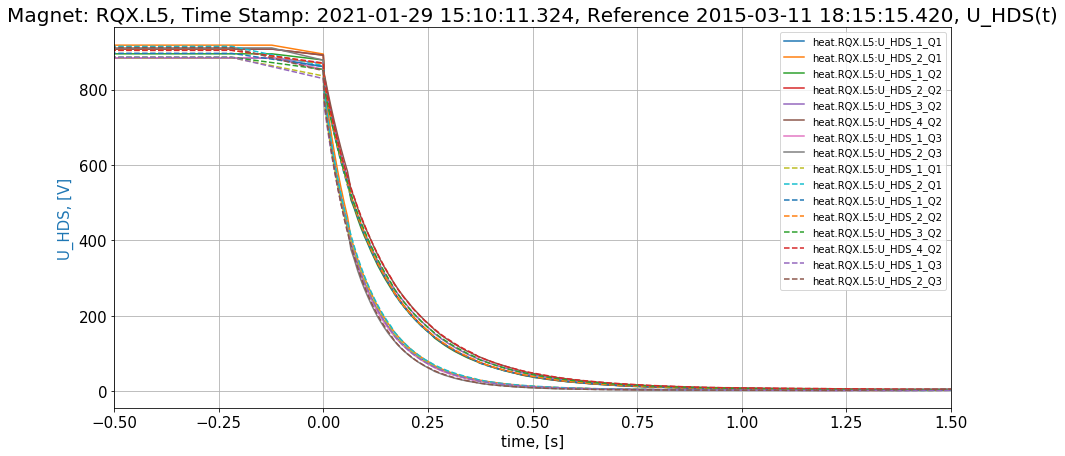

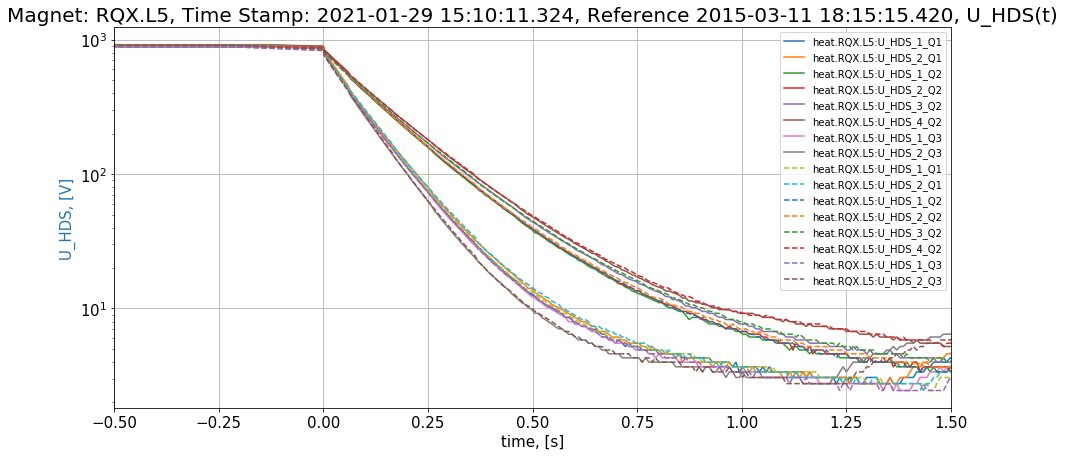

Comparison of the inititial and final voltage min max act result 
 
 heat.RQX.L5:U_HDS_1_Q1:first 
 810.000000 
 1000.000000 
 861.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q1:last20mean 
 0.000000 
 10.000000 
 3.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q2:first 
 810.000000 
 1000.000000 
 878.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q2:last20mean 
 0.000000 
 10.000000 
 4.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q3:first 
 810.000000 
 1000.000000 
 854.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q3:last20mean 
 0.000000 
 10.000000 
 3.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q1:first 
 810.000000 
 1000.000000 
 894.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q1:last20mean 
 0.000000 
 10.000000 
 3.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q2:first 
 810.000000 
 1000.000000 
 891.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q2:last20mean 
 0.000000 
 10.000000 
 4.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q3:first 
 810.000000 
 1000.000000 
 878.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q3:last20mean 
 0.000000 
 10.000000 
 3.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_3_Q2:first 
 810.000000 
 1000.000000 
 869.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_3_Q2:last20mean 
 0.000000 
 10.000000 
 4.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_4_Q2:first 
 810.000000 
 1000.000000 
 891.000000 
 True 
 
 
 heat.RQX.L5:U_HDS_4_Q2:last20mean 
 0.000000 
 10.000000 
 6.000000 
 True 
 
 Comparison of the discharge characteristic time to the reference ref act diff result 
 
 heat.RQX.L5:U_HDS_1_Q1:tau_charge 
 0.103000 
 0.099000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q1:tau_charge 
 0.103000 
 0.100000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q2:tau_charge 
 0.151000 
 0.148000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q2:tau_charge 
 0.152000 
 0.148000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_3_Q2:tau_charge 
 0.160000 
 0.157000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_4_Q2:tau_charge 
 0.165000 
 0.162000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_1_Q3:tau_charge 
 0.101000 
 0.098000 
 0.005000 
 True 
 
 
 heat.RQX.L5:U_HDS_2_Q3:tau_charge 
 0.093000 
 0.091000 
 0.005000 
 True

The QH discharges are labeled: Pass.


In [22]:
if u_hds_dfs:
    it_analysis.analyze_single_qh_voltage_with_ref(circuit_name, timestamp_qds, u_hds_dfs, u_hds_ref_dfs)
else:
    print("No Quench Heater discharges!")

# 7. Final Report

In [23]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
mp3_results_table = it_analysis.create_mp3_results_table()
display(HTML(mp3_results_table.T.to_html()))

In [24]:
analysis_start_time = Time.get_analysis_start_time()
date_time_fgc = Time.to_datetime(timestamp_fgc).strftime("%Y-%m-%d-%Hh%M")
report_destination_path = report_destination_path_template.format(circuit_name)
report_filename = report_filename_template.format(circuit_name, date_time_fgc, analysis_start_time)

!mkdir -p $report_destination_path

csv_path = f"{report_destination_path}/{report_filename}.csv"
mp3_results_table.to_csv(csv_path, index=False)
print("MP3 results table saved to (Windows): " + "\\\\cernbox-smb" + csv_path.replace("/", "\\"))

html_filename = f"{report_filename}.html"
html_path = f"{report_destination_path}/{report_filename}.html"
print("Compact notebook report saved to (Windows): " + "\\\\cernbox-smb" + html_path.replace("/", "\\"))
apply_report_template()
display(Javascript("IPython.notebook.save_notebook();"))
Time.sleep(5)
!{sys.executable} -m jupyter nbconvert --to html $path_to_notebook --output-dir $report_destination_path --output $html_filename --TemplateExporter.exclude_input=True --TagRemovePreprocessor.remove_all_outputs_tags skip_output --TagRemovePreprocessor.remove_cell_tags skip_cell

MP3 results table saved to (Windows): \\cernbox-smb.\results\reports\AN_IT_FPA.csv
Compact notebook report saved to (Windows): \\cernbox-smb.\results\reports\AN_IT_FPA.html


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook ./results/notebooks/result_AN_IT_FPA.ipynb to html


[NbConvertApp] Writing 1195524 bytes to ./results/reports/AN_IT_FPA.html
